In [1]:
from linares_plot import *
import os
import datetime
from datetime import datetime as dt
import re
import statsmodels.formula.api as smf
import random

In [2]:
df = pd.read_excel('C:\\Users\\David\\Desktop\\David\\risa_aplausos\\df_subjects.xlsx')
df.head()

,duration,event,subject,tiempo,time_s,trick,RT,previous_event,anticip_time,next_event,r1,r2,r3,r4
0,1,Se,1,00:00:06,6,1,-1,None,-21,gag,0,0,0,0
1,1,Si,1,00:00:10,10,1,-1,None,-17,gag,0,0,0,0
2,102,N,1,00:00:12,12,1,-1,None,-15,gag,0,0,0,0
3,1,In,1,00:00:32,32,1,5,gag,-2,gag,0,0,0,0
4,1,In,1,00:01:02,62,1,16,inicio,-3,gag,0,0,0,0


In [3]:
##Actions Gea data
df_gea=pd.read_excel(os.getcwd() + '\\EVENTOS_GEA.xlsx', sheet_name='Hoja2' )
times_s = [df_gea.tiempo.iloc[i].minute*60 + df_gea.tiempo.iloc[i].second for i in range(len(df_gea))]
df_gea['times_s'] = times_s

### cambiar tiempo y tiempo_s por los corregidos, en los que se restan 10 minutos, 31 segundos. De esta manera, 
### los dos dataframes están sincronizados

new_times=[]
times_s_new=[]

for i in range(len(df_gea)):
    #print(i)
    h = df_gea.tiempo.iloc[i]
    h_t = str(h.hour) + ':' + str(h.minute) + ':' + str(h.second) 
    substracting = '00:10:31'
    new_time = dt.strptime(h_t, "%H:%M:%S") - dt.strptime(substracting, "%H:%M:%S")
    new_times.append(new_time)
    ##
    times_s_new.append(df_gea.times_s.loc[i] - (60*10 + 31) ) 

    
df_gea['tiempo'] = new_times 
df_gea['times_s'] = times_s_new 

df_gea = df_gea.sort_values(by=['times_s'])

df_gea= df_gea.reset_index()
df_gea = df_gea[['tiempo', 'evento', 'decripcion', 'times_s']]
df_gea['evento_'] = df_gea['evento'].copy()
df_gea['evento_'] = df_gea['evento_'].replace(['Miniclimax', 'Climax final' ], ['climax', 'climax']) #for simplicity
df_gea.head()

,tiempo,evento,decripcion,times_s,evento_
0,00:00:27,gag,broma sobre su dominio del catalán,27,gag
1,00:00:34,gag,"""Por deferencia""",34,gag
2,00:00:46,inicio,Abre el estuche de la baraja,46,inicio
3,00:01:05,gag,"""Que haya público""",65,gag
4,00:01:19,gag,"""El público de schroedinger""",79,gag


In [4]:
times_strat_trick = df_gea.loc[df_gea['evento']=='inicio'].times_s.values

trick_ = []
for i in range(len(df)):
    t_ev = df.iloc[i].time_s
    if t_ev<=times_strat_trick[0]:
        trick_.append(0)
    elif t_ev<=times_strat_trick[1]:
        trick_.append(1)
    elif t_ev<=times_strat_trick[2]:
        trick_.append(2)
    elif t_ev<=times_strat_trick[3]:
        trick_.append(3)
    elif t_ev<=times_strat_trick[4]:
        trick_.append(4)
    elif t_ev<=times_strat_trick[5]:
        trick_.append(5)        
    elif t_ev<=times_strat_trick[6]:
        trick_.append(6)
    elif t_ev<=times_strat_trick[7]:
        trick_.append(7)
    elif t_ev>times_strat_trick[7]:
        trick_.append(8)

### 
df['trick_'] = trick_

In [27]:
df.event.unique()

array(['Se', 'Si', 'N', 'In', 'L', 'S', 'I', 'a', 'F', 'C', 'A', 'B', 'R',
       'O', 'D', 'P', 'M', 'AA', 'A+', 'a+', 'AA+', 'T', 'VP'],
      dtype=object)

In [28]:
results_mem=[]

events = ['sonrisa', 'risa', 'aplauso', 'side', 'inmovil', 'facial' ]
cond_ev_list = [(df['event']=='S') ,
               (df['event']=='R') ,
               ((df['event']=='S') | (df['event']=='R')),
               ((df['event']=='A')  | (df['event']=='a') | (df['event']=='AA') | (df['event']=='A+') | (df['event']=='AA+') | (df['event']=='a+')),
               ((df['event']=='I') | (df['event']=='D')),
               (df['event']=='In'),
               (df['event']=='F')
               ]



for idx_ev , Event in enumerate(events):
    COND_EV = cond_ev_list[idx_ev]
    for Subject in df.subject.unique():
        for trick in [1,2,3,4,5,6,7,8]:
            ####
            df_e = df.loc[(df['previous_event']=='Climax final') & (df['RT']<10) 
                   & (df['subject']==Subject)  & (df['trick_']==trick)  & COND_EV  ]

            if len(df_e) == 0:
                duration_ = 0
            else:
                duration_ = df_e.duration.sum() ##por si hay más de uno

            #####
            r1 = df.loc[(df['subject']==Subject)  & (df['trick']==trick)   ].r1.iloc[0]
            r2 = df.loc[(df['subject']==Subject)  & (df['trick']==trick)   ].r2.iloc[0]
            r3 = df.loc[(df['subject']==Subject)  & (df['trick']==trick)   ].r3.iloc[0]
            r4 = df.loc[(df['subject']==Subject)  & (df['trick']==trick)   ].r4.iloc[0]
            #####
            res_m = pd.DataFrame(np.array([[Subject, trick, duration_, r1, 0, Event],
                               [Subject, trick, duration_, r2,10, Event],
                               [Subject, trick, duration_, r3,45, Event],
                               [Subject, trick, duration_, r4,135, Event]]) )
            results_mem.append(res_m)

In [29]:
results_mem_S = pd.concat(results_mem)
results_mem_S.columns=['subject', 'trick', 'duration', 'memory', 'time', 'event']
results_mem_S = results_mem_S.loc[results_mem_S['memory']!='Miss']
results_mem_S['memory'] = results_mem_S['memory'].replace(['0', '1'], [0,1])
#
results_mem_S['time'] = pd.to_numeric(results_mem_S['time'])
results_mem_S['memory'] = pd.to_numeric(results_mem_S['memory'])
results_mem_S['duration'] = pd.to_numeric(results_mem_S['duration'])
results_mem_S['trick'] = pd.to_numeric(results_mem_S['trick'])
results_mem_S['subject'] = pd.to_numeric(results_mem_S['subject'])

results_mem_S.head()

,subject,trick,duration,memory,time,event
0,1,1,8,0,0,sonrisa
1,1,1,8,0,10,sonrisa
2,1,1,8,0,45,sonrisa
3,1,1,8,0,135,sonrisa
0,1,2,6,0,0,sonrisa


In [ ]:
## Memory at t0

No handles with labels found to put in legend.


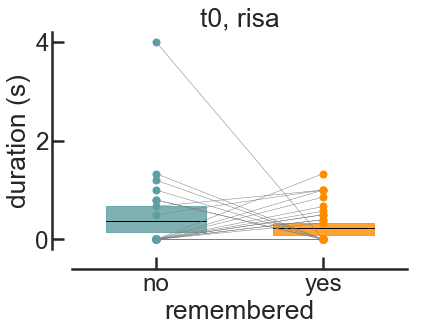

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memory   
No. Observations: 304     Method:             REML     
No. Groups:       38      Scale:              0.2269   
Min. group size:  8       Likelihood:         -210.5365
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.661    0.029 23.124 0.000  0.605  0.717
duration     -0.036    0.028 -1.291 0.197 -0.090  0.019
Group Var     0.000    0.015                           



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [18]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa')],  
                palette=['cadetblue', 'darkorange'], point_size=0, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)



for i in results_mem_S.subject.unique():
     #######
    plt.plot([0,1], 
             [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean(), 
              results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()],
              'grey', linewidth=0.5)
    plt.plot([0], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='cadetblue', markersize=7 )
    plt.plot([1], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='darkorange', markersize=7 )






plt.gca().set_xlabel('remembered')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
# plt.gca().set_ylim(-5,25)
# plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, risa')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa'), 'subject'])
mdf = md.fit()
print(mdf.summary())

No handles with labels found to put in legend.


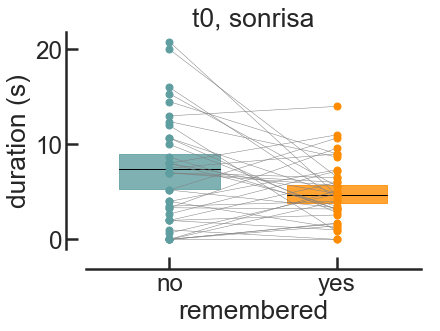

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memory   
No. Observations: 304     Method:             REML     
No. Groups:       38      Scale:              0.2216   
Min. group size:  8       Likelihood:         -208.7184
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.715    0.034 20.953 0.000  0.648  0.781
duration     -0.011    0.004 -3.035 0.002 -0.019 -0.004
Group Var     0.000    0.016                           



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [22]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa')],  
                palette=['cadetblue', 'darkorange'], point_size=0, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)



for i in results_mem_S.subject.unique():
     #######
    plt.plot([0,1], 
             [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean(), 
              results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()],
              'grey', linewidth=0.5)
    plt.plot([0], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='cadetblue', markersize=7 )
    plt.plot([1], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='darkorange', markersize=7 )






plt.gca().set_xlabel('remembered')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
# plt.gca().set_ylim(-5,25)
# plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, sonrisa')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa'), 'subject'])
mdf = md.fit()
print(mdf.summary())

No handles with labels found to put in legend.


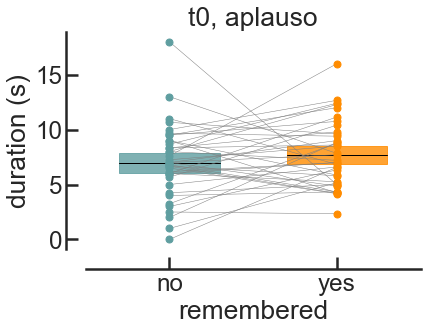

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memory   
No. Observations: 304     Method:             REML     
No. Groups:       38      Scale:              0.2265   
Min. group size:  8       Likelihood:         -212.8269
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.623    0.043 14.592 0.000  0.539  0.706
duration      0.004    0.004  0.891 0.373 -0.005  0.012
Group Var     0.002    0.016                           



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso')],  
                palette=['cadetblue', 'darkorange'], point_size=0, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)



for i in results_mem_S.subject.unique():
     #######
    plt.plot([0,1], 
             [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean(), 
              results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()],
              'grey', linewidth=0.5)
    plt.plot([0], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='cadetblue', markersize=7 )
    plt.plot([1], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='darkorange', markersize=7 )






plt.gca().set_xlabel('remembered')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
# plt.gca().set_ylim(-5,25)
# plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, aplauso')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso'), 'subject'])
mdf = md.fit()
print(mdf.summary())

No handles with labels found to put in legend.


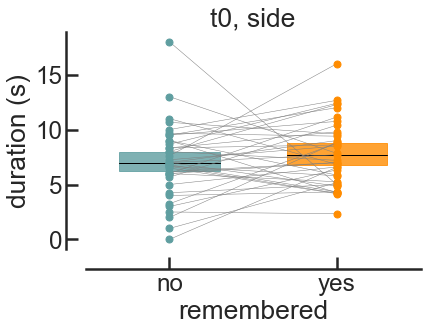

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memory   
No. Observations: 304     Method:             REML     
No. Groups:       38      Scale:              0.2265   
Min. group size:  8       Likelihood:         -212.8269
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.623    0.043 14.592 0.000  0.539  0.706
duration      0.004    0.004  0.891 0.373 -0.005  0.012
Group Var     0.002    0.016                           



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [25]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='side')],  
                palette=['cadetblue', 'darkorange'], point_size=0, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)



for i in results_mem_S.subject.unique():
     #######
    plt.plot([0,1], 
             [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='side') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean(), 
              results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='side') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()],
              'grey', linewidth=0.5)
    plt.plot([0], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='side') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='cadetblue', markersize=7 )
    plt.plot([1], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='side') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='darkorange', markersize=7 )






plt.gca().set_xlabel('remembered')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
# plt.gca().set_ylim(-5,25)
# plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, side')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='side')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='side'), 'subject'])
mdf = md.fit()
print(mdf.summary())

No handles with labels found to put in legend.


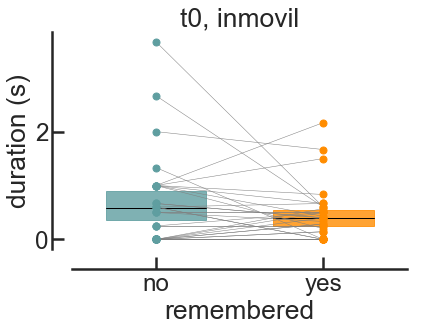

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memory   
No. Observations: 304     Method:             REML     
No. Groups:       38      Scale:              0.2241   
Min. group size:  8       Likelihood:         -210.0876
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.673    0.032 21.256 0.000  0.611  0.735
duration     -0.046    0.030 -1.557 0.119 -0.105  0.012
Group Var     0.003    0.016                           



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [26]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='inmovil')],  
                palette=['cadetblue', 'darkorange'], point_size=0, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)



for i in results_mem_S.subject.unique():
     #######
    plt.plot([0,1], 
             [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='inmovil') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean(), 
              results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='inmovil') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()],
              'grey', linewidth=0.5)
    plt.plot([0], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='inmovil') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='cadetblue', markersize=7 )
    plt.plot([1], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='inmovil') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='darkorange', markersize=7 )






plt.gca().set_xlabel('remembered')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
# plt.gca().set_ylim(-5,25)
# plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, inmovil')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='inmovil')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='inmovil'), 'subject'])
mdf = md.fit()
print(mdf.summary())

In [ ]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='facial')],  
                palette=['cadetblue', 'darkorange'], point_size=0, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)



for i in results_mem_S.subject.unique():
     #######
    plt.plot([0,1], 
             [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='facial') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean(), 
              results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='facial') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()],
              'grey', linewidth=0.5)
    plt.plot([0], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='facial') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='cadetblue', markersize=7 )
    plt.plot([1], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='facial') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='darkorange', markersize=7 )






plt.gca().set_xlabel('remembered')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
# plt.gca().set_ylim(-5,25)
# plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, facial')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='facial')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='facial'), 'subject'])
mdf = md.fit()
print(mdf.summary())

In [28]:
##sonrisa t=0

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


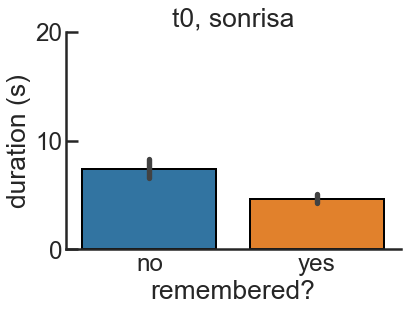

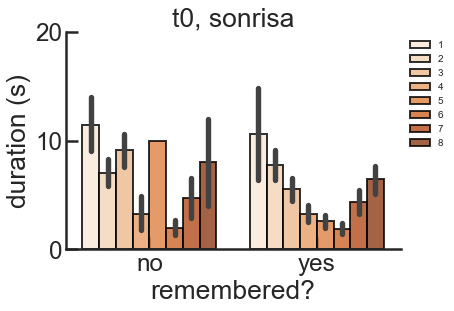

In [39]:
plt.figure()
sns.barplot(x="memory", y="duration",
                data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa')], estimator=np.mean, 
                  ci=68, edgecolor='black', ecolor='k', alpha=1.)

plt.gca().set_xlabel('remembered?')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
plt.gca().set_ylim(0,20)
plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, sonrisa')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()

#######################
#######################
#######################

sns.barplot(x="memory", y="duration", hue='trick', hue_order=[1,2,3,4,5,6,7,8],
                data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa')], estimator=np.mean, 
                  ci=68, palette='Oranges', edgecolor='black', ecolor='k', alpha=0.8)

plt.gca().set_xlabel('remembered?')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
plt.gca().set_ylim(0,20)
plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, sonrisa')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)

In [ ]:
##aplausos t=0

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


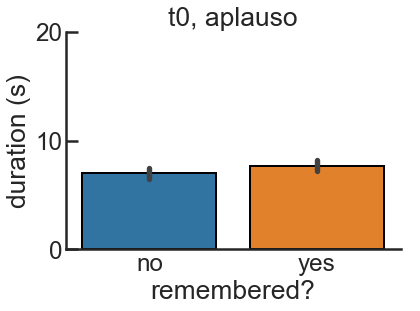

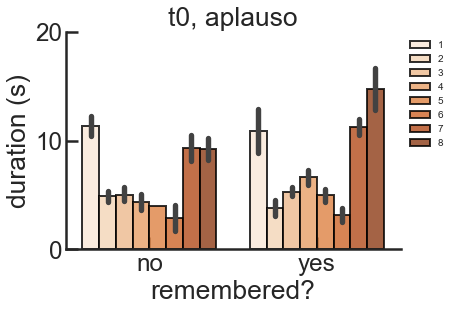

In [42]:
plt.figure()
sns.barplot(x="memory", y="duration",
                data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso')], estimator=np.mean, 
                  ci=68, edgecolor='black', ecolor='k', alpha=1.)

plt.gca().set_xlabel('remembered?')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
plt.gca().set_ylim(0,20)
plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, aplauso')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()

#######################
#######################
#######################

sns.barplot(x="memory", y="duration", hue='trick', hue_order=[1,2,3,4,5,6,7,8],
                data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso')], estimator=np.mean, 
                  ci=68, palette='Oranges', edgecolor='black', ecolor='k', alpha=0.8)

plt.gca().set_xlabel('remembered?')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
plt.gca().set_ylim(0,20)
plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, aplauso')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)

No handles with labels found to put in legend.


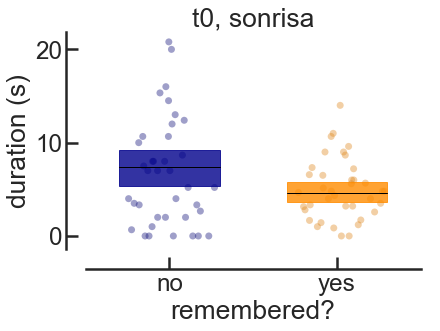

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memory   
No. Observations: 304     Method:             REML     
No. Groups:       38      Scale:              0.2216   
Min. group size:  8       Likelihood:         -208.7184
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.715    0.034 20.953 0.000  0.648  0.781
duration     -0.011    0.004 -3.035 0.002 -0.019 -0.004
Group Var     0.000    0.016                           



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [12]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa')],  
                palette=['darkblue', 'darkorange'], point_size=7, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)

plt.gca().set_xlabel('remembered?')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
# plt.gca().set_ylim(-5,25)
# plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, sonrisa')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='sonrisa'), 'subject'])
mdf = md.fit()
print(mdf.summary())

No handles with labels found to put in legend.


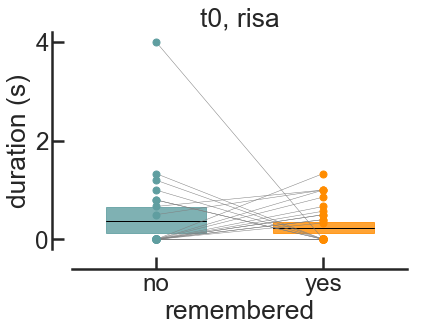

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memory   
No. Observations: 304     Method:             REML     
No. Groups:       38      Scale:              0.2269   
Min. group size:  8       Likelihood:         -210.5365
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.661    0.029 23.124 0.000  0.605  0.717
duration     -0.036    0.028 -1.291 0.197 -0.090  0.019
Group Var     0.000    0.015                           



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [17]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa')],  
                palette=['cadetblue', 'darkorange'], point_size=0, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)



for i in results_mem_S.subject.unique():
     #######
    plt.plot([0,1], 
             [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean(), 
              results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()],
              'grey', linewidth=0.5)
    plt.plot([0], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa') & (results_mem_S['memory']==0) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='cadetblue', markersize=7 )
    plt.plot([1], [results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa') & (results_mem_S['memory']==1) & (results_mem_S['subject']==i), 'duration'].mean()], marker='o', color='darkorange', markersize=7 )






plt.gca().set_xlabel('remembered')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
# plt.gca().set_ylim(-5,25)
# plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, risa')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='risa'), 'subject'])
mdf = md.fit()
print(mdf.summary())

No handles with labels found to put in legend.


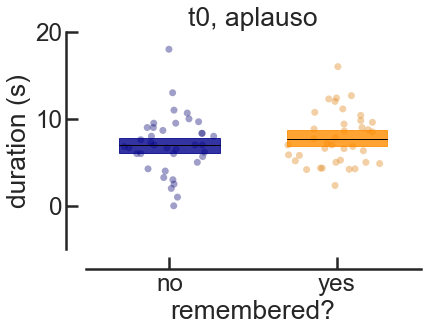

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: memory   
No. Observations: 304     Method:             REML     
No. Groups:       38      Scale:              0.2265   
Min. group size:  8       Likelihood:         -212.8269
Max. group size:  8       Converged:          Yes      
Mean group size:  8.0                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.623    0.043 14.592 0.000  0.539  0.706
duration      0.004    0.004  0.891 0.373 -0.005  0.012
Group Var     0.002    0.016                           



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [10]:
plt.figure()
linares_plot(x="memory", y="duration", order=[0,1], 
                df=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso')],  
                palette=['darkblue', 'darkorange'], point_size=7, reps=100,
                by_subj=True, subj_col='subject',fill_box=True, CI=0.95, alpha_box=0.8)

plt.gca().set_xlabel('remembered?')
plt.gca().set_ylabel('duration (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
plt.gca().set_ylim(-5,20)
plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('t0, aplauso')
plt.legend(bbox_to_anchor=(1,1), loc="upper left", frameon=False, fontsize=10)
plt.show()


md = smf.mixedlm('memory~duration', 
                 data=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso')],
                 groups=results_mem_S.loc[(results_mem_S['time']==0) & (results_mem_S['event']=='aplauso'), 'subject'])
mdf = md.fit()
print(mdf.summary())

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


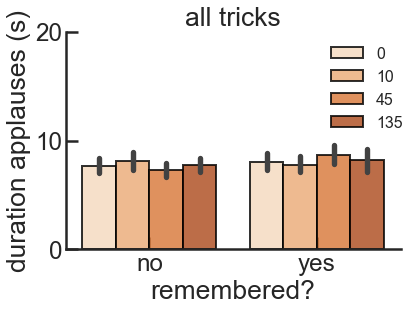

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4606
Date:                Sun, 18 Apr 2021   Prob (F-statistic):              0.710
Time:                        12:22:55   Log-Likelihood:                -2845.0
No. Observations:                 864   AIC:                             5698.
Df Residuals:                     860   BIC:                             5717.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.2827      0.438     16.628      

In [11]:
plt.figure()
sns.barplot(x="memory", y="duration", hue='time', hue_order=[0,10,45,135],
                data=results_mem_S, estimator=np.mean, 
                  ci=68, palette='Oranges', edgecolor='black', ecolor='k', alpha=0.8)

plt.gca().set_xlabel('remembered?')
plt.gca().set_ylabel('duration applauses (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().tick_params(direction='in') #direction
plt.gca().set_ylim(0,20)
plt.gca().set_yticks([0, 10,20])
plt.gca().tick_params(direction='in') #direction
plt.gca().set_xticklabels(['no', 'yes'])

plt.gca().set_title('all tricks')

h, l = plt.gca().get_legend_handles_labels()
labels=['0', '10', '45', '135']
plt.gca().legend(h, labels, title="", frameon=False, prop={'size': 16}, bbox_to_anchor=(1.05, 1))

plt.show()



#####
Tx= results_mem_S
Tx['subject'] = pd.to_numeric(Tx['subject'])
Tx['memory'] = pd.to_numeric(Tx['memory'])
Tx['duration'] = pd.to_numeric(Tx['duration'])
Tx['time'] = pd.to_numeric(Tx['time'])
##ç

r = smf.ols(formula='duration~time*memory', data=Tx).fit()
print(r.summary())

r = smf.ols(formula='duration~time', data=Tx.loc[Tx['memory']==1]).fit()
print(r.summary())